In [21]:
import sys
import os
import pandas as pd
from datetime import datetime
from helper_functions import fetch_granular_data,fetch_and_save_csv_files, csv_to_df
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load aggregate data from CSVs
def load_csvs_from_data_folder(data_folder, date_str):
    # Create the path to the data folder for the given date
    date_folder_path = os.path.join(data_folder, date_str)
    # print(date_folder_path)
    
    # Check if the folder exists
    if not os.path.exists(date_folder_path) and len(os.listdir(date_folder_path)) == 0:
        fetch_and_save_csv_files()
        # return None
    
    # Dictionary to hold dataframes
    dataframes = {}
    dataframes = csv_to_df(date_folder_path)
    return dataframes
    
#Todays date
today_str = datetime.now().strftime('%Y-%m-%d')
data_folder = '..\\data'

# Load dataframes from CSVs
dfs = load_csvs_from_data_folder(data_folder, today_str)


In [22]:
def perform_eda(df, name):
    print(f"EDA for {name}:")
    
    # print("\nFirst few rows:")
    # print(df.iloc[:,:5].head())
    
    print("\nInfo:")
    df.info()
    
    # Display basic statistics
    # print("\nDescribe:")
    # print(df.describe())
    
    # Check for null values
    # print("\nNull values:")
    # print(df.isnull().sum())
    
    # Check for duplicate rows
    # print("\nNumber of duplicate rows:")
    # print(df.duplicated().sum())

# Perform EDA on each dataframe
for name, df in dfs.items():
    perform_eda(df, name)
    print("\n" + "="*50 + "\n")

EDA for donations_facility:

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145046 entries, 0 to 145045
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     145046 non-null  datetime64[ns]
 1   hospital                 145046 non-null  object        
 2   daily                    145046 non-null  int64         
 3   blood_a                  145046 non-null  int64         
 4   blood_b                  145046 non-null  int64         
 5   blood_o                  145046 non-null  int64         
 6   blood_ab                 145046 non-null  int64         
 7   location_centre          145046 non-null  int64         
 8   location_mobile          145046 non-null  int64         
 9   type_wholeblood          145046 non-null  int64         
 10  type_apheresis_platelet  145046 non-null  int64         
 11  type_apheresis_plasma    145046 non-null  i

In [23]:
#Observing the values in the state columns
dfs['donations_state']['state'].value_counts()

#Malaysia is not a state

state
Malaysia             6593
Johor                6593
Kedah                6593
Kelantan             6593
Melaka               6593
Negeri Sembilan      6593
Pahang               6593
Perak                6593
Pulau Pinang         6593
Sabah                6593
Sarawak              6593
Selangor             6593
Terengganu           6593
W.P. Kuala Lumpur    6593
Name: count, dtype: int64

In [24]:
# Define the main outputs and the corresponding columns in your dataframes
variable_outputs = {
    'blood_type': ['blood_a', 'blood_b', 'blood_o', 'blood_ab'],
    'location': ['location_centre', 'location_mobile'],
    'donation_type': ['type_wholeblood', 'type_apheresis_platelet', 'type_apheresis_plasma', 'type_other'],
    'social_class': ['social_civilian', 'social_student', 'social_policearmy'],
    'donation_regularity': ['donations_new', 'donations_regular', 'donations_irregular'],
}

#Lets answer the question on why is there a malaysia state
donations_state = dfs['donations_state']
donations_state.loc[:,'date'] = pd.to_datetime(donations_state['date'])
donations_state.set_index('date',inplace=True)
malaysia_total = donations_state[donations_state['state'] == 'Malaysia']['daily'].sum()
state_total = donations_state[donations_state['state'] != 'Malaysia']['daily'].sum()
print(malaysia_total)
print(state_total)

8280488
8280488


Okay evidently its just an aggregate of all the states on any given date. Therefore lets separate it as a different df.


In [25]:
# Separate the data into two DataFrames: one for Malaysia and one for the states
ms_df = donations_state.loc[donations_state['state'] == 'Malaysia', :]
state_df = donations_state.loc[donations_state['state'] != 'Malaysia', :]

In [26]:
# Check the first few rows to ensure the DataFrame looks as expected
print(state_df.loc[ :,['state','daily'] ].head())
print(ms_df.loc[:,'daily'].head())

            state  daily
date                    
2006-01-01  Johor     87
2006-01-02  Johor     15
2006-01-03  Johor      8
2006-01-04  Johor     33
2006-01-05  Johor     20
date
2006-01-01    525
2006-01-02    227
2006-01-03    112
2006-01-04    391
2006-01-05    582
Name: daily, dtype: int64


Lets analyse the states first.


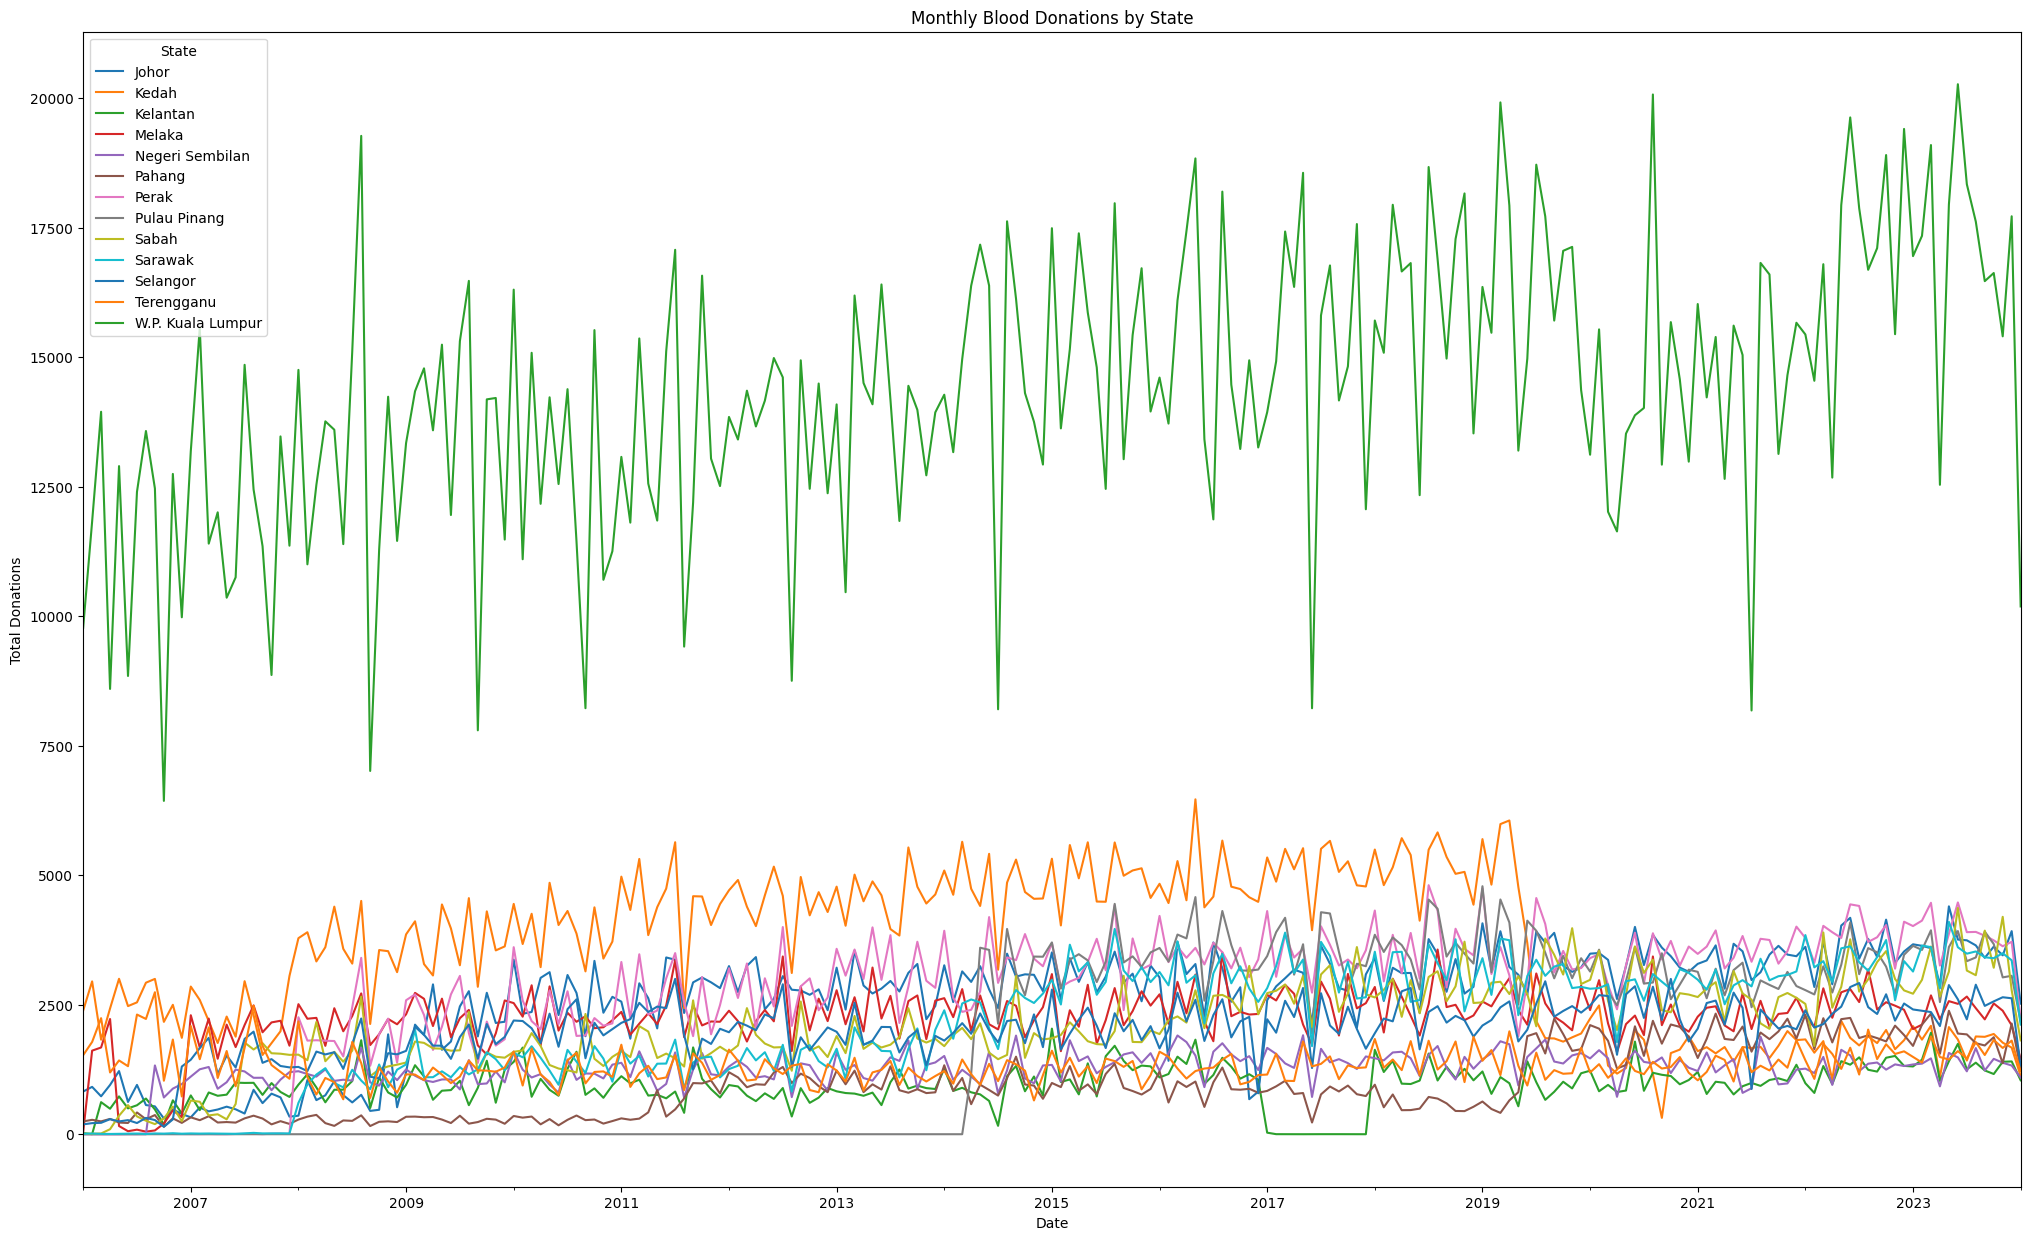

In [27]:
# Group the data by state and resample to a monthly frequency, summing the daily donations
monthly_donations_by_state = state_df.groupby('state').resample('M').sum().loc[:, 'daily']

# Plotting the trends
plt.figure(figsize=(25, 15))
for state in monthly_donations_by_state.index.get_level_values(0).unique():
    monthly_donations_by_state.xs(state, level='state').plot(label=state)
plt.title('Monthly Blood Donations by State')
plt.xlabel('Date')
plt.ylabel('Total Donations')
plt.legend(title='State')
plt.show()


In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose as sm

monthly_donations_by_state = state_df.groupby(['state', pd.Grouper(key='date', freq='M')]).sum()

# Pivot the table to have states as columns and dates as rows
monthly_donations_by_state = monthly_donations_by_state.unstack(level=0)

print(monthly_donations_by_state)

state       Johor  Kedah  Kelantan  Melaka  Negeri Sembilan  Pahang  Perak  \
date                                                                         
2006-01-31    824   2386        21      40                0     247      2   
2006-02-28    914   2950         1    1613                0     278      2   
2006-03-31    732   1824       619    1674                0     248      1   
2006-04-30    951   2428       492    2224                1     295      4   
2006-05-31   1219   3000       730     158                0     225      1   
...           ...    ...       ...     ...              ...     ...    ...   
2023-09-30   3404   1880      1231    2217             1231    1713   3832   
2023-10-31   3621   1935      1162    2524             1455    1872   3742   
2023-11-30   3453   1767      1398    2384             1380    1370   3628   
2023-12-31   3920   1671      1405    2102             1326    2137   3714   
2024-01-31   2520   1123      1041    1449             1094    1

In [51]:
def decompose_and_plot(state, df, mean_donations = None, model='additive'):
    # Check if the state's data exists in the DataFrame
    if state not in df.columns:
        print(f"No data for state: {state}")
        return
    
    if mean_donations is not None:
        rank = mean_donations.rank(ascending=False)[state]
    
    # Perform seasonal decomposition
    series = df[state].dropna()  # Drop NA values for decomposition
    decomposition = sm(series, model=model, period=12)  # Monthly data usually has a period of 12
    
    # Plot the decomposed components
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
    decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
   
    if mean_donations is not None : 
        plt.suptitle(f'Seasonal Decompose of {state} Blood Donations (Rank {int(rank)})')
    else:
        plt.suptitle(f'Seasonal Decompose of {state} Blood Donations')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
    plt.show()

# Calculate mean donations per state to determine highest and lowest
mean_donations = monthly_donations_by_state.mean().sort_values()

# Take two states with the highest and two with the lowest mean donations
if mean_donations is not None:
    high_states = mean_donations.index[-2:]
    low_states = mean_donations.index[:2]

# print(high_states)
# print(low_states)
# Decompose and plot for the selected states
# for state in high_states.union(low_states):
#     decompose_and_plot(state, monthly_donations_by_state, 'multiplicative')

#Doesnt work with multiplicative!


In [44]:
def df_cleans_before_decompose(df):
    #Forward-fill, replace NA and ensure no negative values in the dataset
    df.ffill()
    df.fillna(0,inplace=True)
    df[df < 0] = 0
    return df

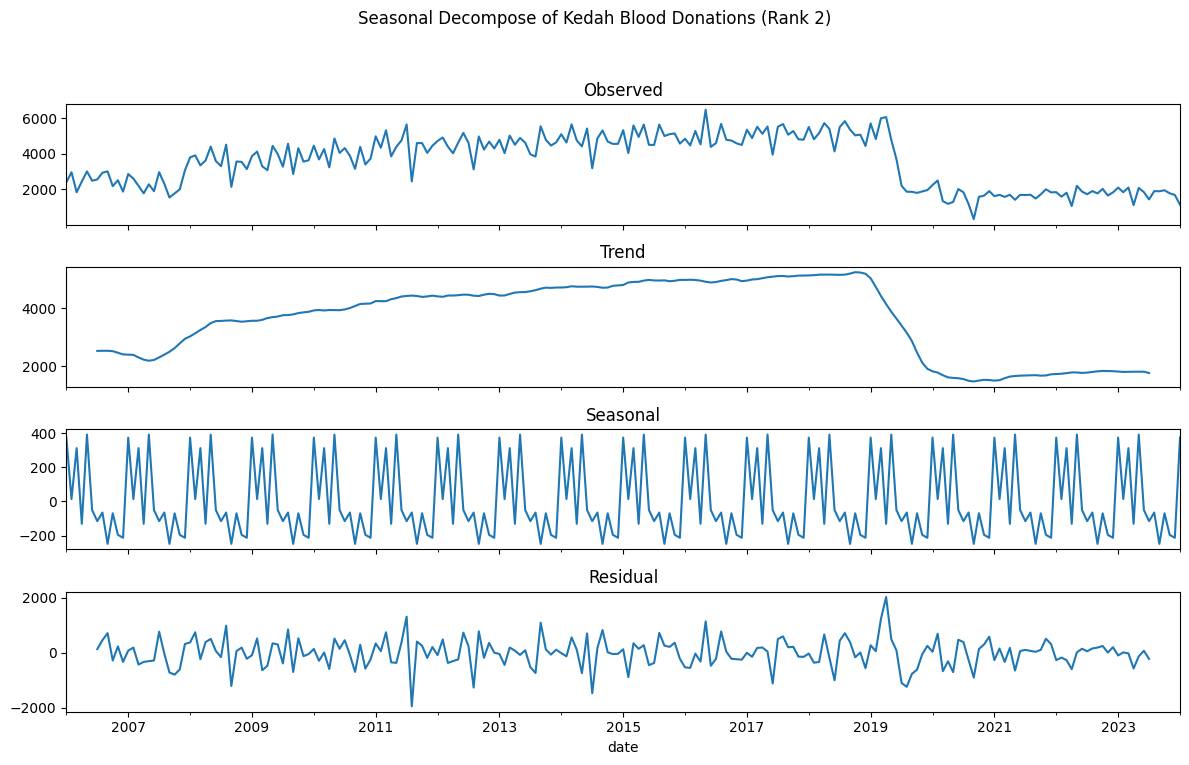

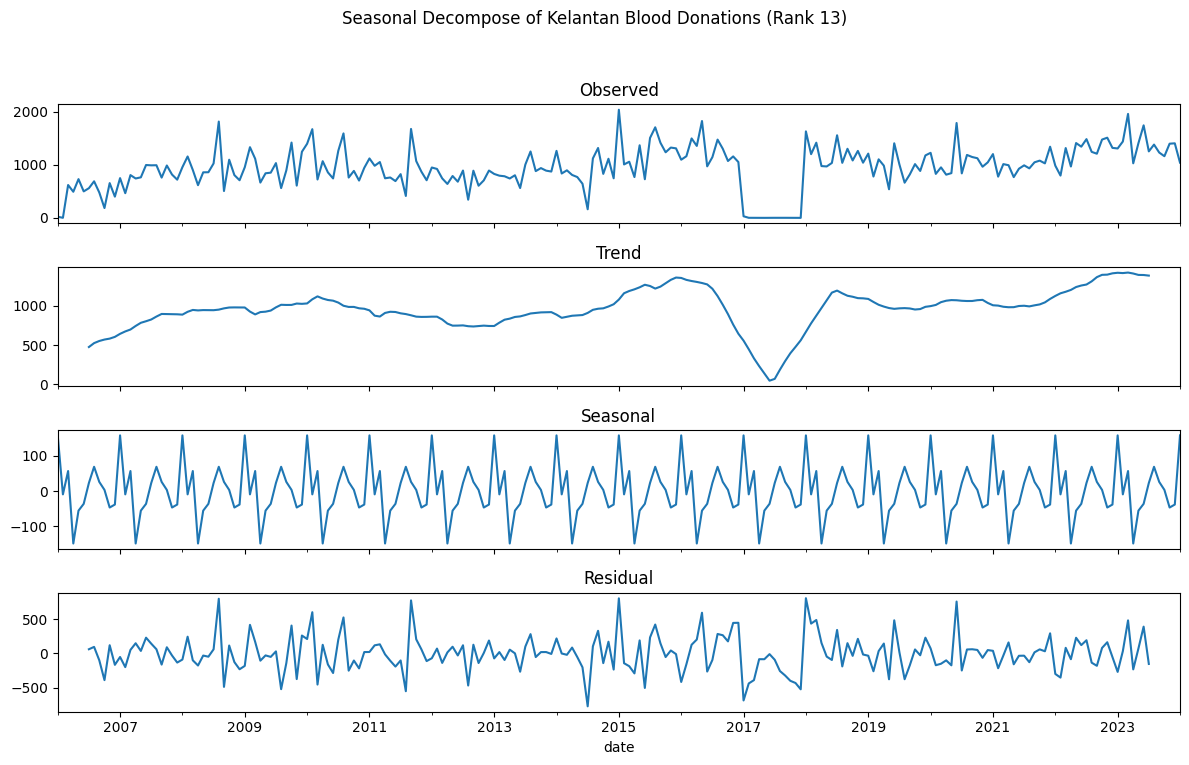

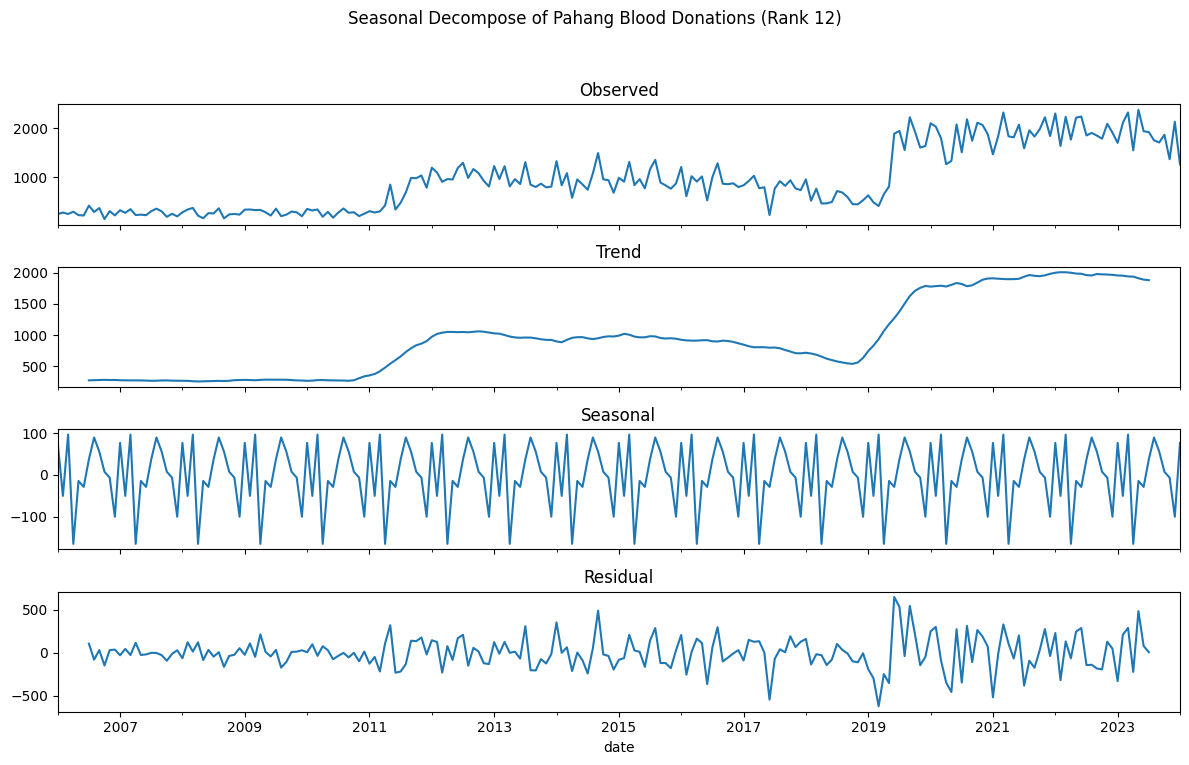

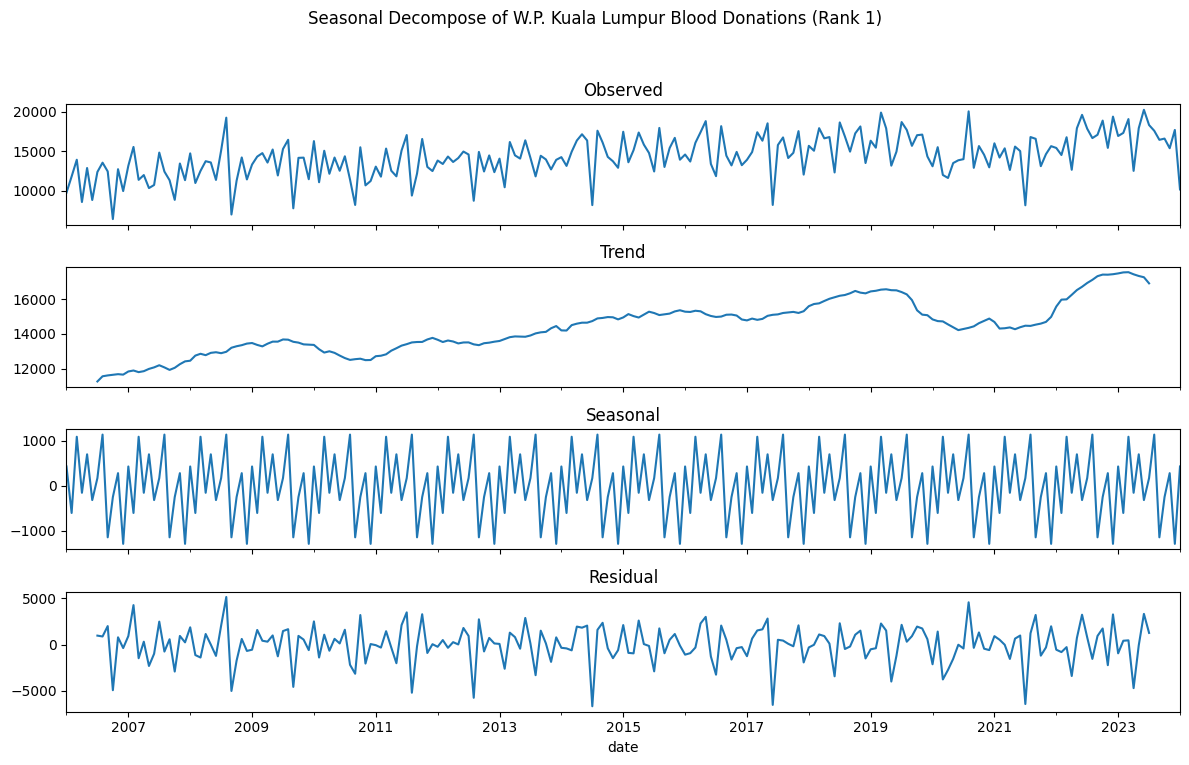

In [58]:
monthly_donations_by_state_ffill = df_cleans_before_decompose(monthly_donations_by_state)
# Now, we can safely proceed with an additive model
for state in high_states.union(low_states):
    decompose_and_plot(state, monthly_donations_by_state_ffill, mean_donations,model= 'additive')

state       Malaysia
date                
2006-01-31     15027
2006-02-28     19600
2006-03-31     21524
2006-04-30     16575
2006-05-31     20264
...              ...
2023-09-30     47237
2023-10-31     47598
2023-11-30     45806
2023-12-31     47618
2024-01-31     29517

[217 rows x 1 columns]


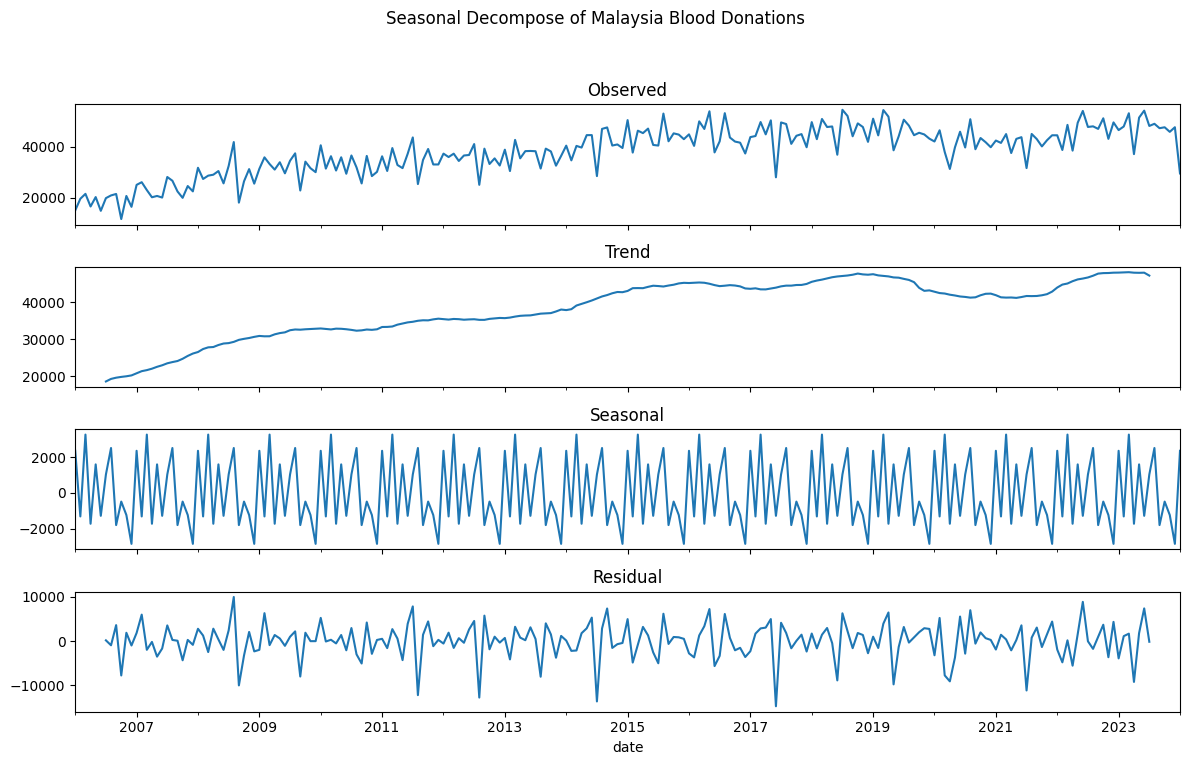

In [55]:
# Seasonal decompose of Malaysia
monthly_donations_malaysia = ms_df.groupby(['state', pd.Grouper(freq='M')])['daily'].sum().unstack(level=0)
decompose_and_plot('Malaysia',monthly_donations_malaysia,model='additive' )